In [13]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.relativedelta as dr
import pandas_datareader as pdr
import cvxopt as opt
import time
import fix_yahoo_finance as yf
from urllib import request
from functools import reduce
from bs4 import BeautifulSoup
from cvxopt import blas, solvers
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
from scipy import optimize
from itertools import compress
from datetime import datetime
from numpy.linalg import inv

In [14]:
def Load_SPX_Tickers( duration , end_date = datetime.now().strftime('%Y-%m-%d') , Makemonthly =True ):
    """ gets S&P 500 ticker list from wikipedia 
                                and historical data from yahoo finance(fixed)"""
    
    req = request.Request('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    opener = request.urlopen(req)
    content = opener.read().decode()
    soup = BeautifulSoup(content, "lxml")
    tables = soup.find_all('table')  
    external_class = tables[0].findAll('a', {'class':'external text'})
    Tickers = []
    for ext in external_class:
        if not 'reports' in ext:
            Tickers.append(ext.string) 
    yf.pdr_override()
    start_date=(datetime.now() - timedelta(days=np.round(duration*(365/12)))).strftime("%Y-%m-%d")
    for i in range(len(Tickers)):            
        Tickers[i]=Tickers[i].replace(".", "-")
    pricehistory = pdr.get_data_yahoo(Tickers, start=start_date, end=end_date)["Adj Close"];   
    print("started with "+str(pricehistory.shape[1]) +" imported stocks")
    if Makemonthly ==True:
        pricehistory = pricehistory.resample("MS").mean()
    return pricehistory

def clean_prices(pricehistory ):
    #deleting anything having a NA
    for St in pricehistory.columns:
        if pricehistory[St].isnull().any():
            del pricehistory[St]
    print("out of which, " +str(pricehistory.shape[1]) + " left to work with after getting rid of NAs")
    return(pricehistory)
def near_psd(x, epsilon=0):
    '''    Calculates the nearest postive semi-definite matrix for a correlation/covariance matrix    '''
    if min(np.linalg.eigvals(x)) > epsilon:
        return x
    print("oops! lets make this matrix right")
    # Removing scaling factor of covariance matrix
    n = x.shape[0]
    var_list = np.array([np.sqrt(x[i,i]) for i in range(n)])
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])
    # getting the nearest correlation matrix
    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    
    # returning the scaling factors
    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])
    return near_cov

def Random_Stocks ( end_date_index, Hreturns , size ,window,Starting_portfolio=[0]):  
    """given the price history selects size number of them as our stocks 
                        form window months before the provided end date to the end_date 
                        and returns the corresponding mu and sigma matrices Return data table and the names"""
    if end_date_index < window:
        raise ValueError('End date index must be greater than your window')
    start = end_date_index -window 
    subtable = Hreturns.iloc[start:end_date_index]
    #getting rid of any data having NA in this time interval:
    for St in subtable.columns:
        if subtable[St].isnull().any():
            del subtable[St]
    if len(Starting_portfolio) <2:
        universe = np.random.choice(range(subtable.shape[1]), size=size,replace=False)
        R = subtable.iloc[:,universe] 
    else:
        R =subtable[Starting_portfolio]
        if R.shape[1] < size:
            print("some stock has popped out!")
    sigma = near_psd(np.cov(R.T))
    if np.any(np.linalg.eigvals(sigma) <= 0):
        global Troubled_sigma 
        Troubled_sigma =sigma
        raise ValueError('The covariance matrix(Troubled_sigma) is not positive definite!')
    mu = pd.DataFrame(R).apply(np.mean)
    return mu , sigma , R 

In [15]:
def markowitz (mu, sigma, ro , long_only=False):
    """For traditional Markowitz model"""
    n = len(mu)
    P = opt.matrix(sigma)
    q = opt.matrix(np.zeros(n))
    if long_only:
        G = -opt.matrix(np.eye(n))
    else:
        G = opt.matrix(0.0, (n ,n))
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix.trans( opt.matrix((list(mu)+[1]*n) , (n,2)))
    b = opt.matrix( [ro,1.0] , (2,1) )  
    solvers.options['show_progress'] = False 
    weights = solvers.qp( P , q, G, h, A, b)
    return list(weights['x']),float(weights["y"][0])

def delta(mu,sigma,R,ro ,weight ,lambda1):
    def grk(x): 
        x=x-mu
        x=opt.matrix(x)
        g2=np.matmul(x,np.transpose(x))
        g = np.transpose(x) + (2/lambda1) * (np.matmul(g2 ,weight) - 
                     np.transpose(reduce(np.dot, [np.transpose(weight),g2,weight,opt.matrix(np.ones(samplesize))])))       
        return g
    Rprime = pd.DataFrame(0.0 , index=R.index, columns=R.columns)
    for i in range(window):
        Rprime.iloc[i,]=grk(R.iloc[i,])
    Zvar = near_psd(np.cov(Rprime.T))
    Randsize = Random_size_for_Zs
    Zs = np.random.multivariate_normal(np.zeros(samplesize),Zvar,Randsize)
    L0 = np.zeros(Randsize)
    denominator = ( 1 - ( np.linalg.norm(mu) ** 4 / reduce(np.dot, [mu.T,sigma,mu])) )
    for i in range(Randsize):
        L0[i] = np.linalg.norm(Zs[i]) ** 2 / denominator
    delta = max(np.percentile(L0,conf_lvl),0) / window
    return delta  

def alpha(delta, ro, weight):
    V0=1.2
    a = min((ro - np.sqrt(delta) * np.linalg.norm(weight) * V0) , ro)
    a = max(a,0)
    return a

def weight_optimizer( mu , sigma , alpha, delta,W0=[0.0]): #remember to impliment lond only later
    if round(sum(W0),5) !=1:
        print("fuck")
        W0 = np.ones(len(mu))/len(mu)      
    def problem (W):
        return (np.sqrt(np.matmul(np.matmul(W.T , sigma),W)) + np.sqrt(delta)* np.linalg.norm(W))**2
    ineq_cons = {'type': 'ineq',
                  'fun' : lambda x: sum(x*mu) - np.sqrt(delta) * np.linalg.norm(x) - alpha ,
                  'jac' : lambda x:    mu     - np.sqrt(delta) * x / np.linalg.norm(x) }
    eq_cons =   {'type': 'eq',
                  'fun' : lambda x: sum(x)-1 ,
                  'jac' : lambda x: np.ones(len(mu))}
    weights = optimize.minimize( problem 
                                , W0 , method='SLSQP', constraints=[eq_cons, ineq_cons] ,tol=1e-7)#,options={'maxiter':20000})
    if not weights.success:
        raise ValueError('Optimizer could not find a solution! something is wrong(do not ask me why!)')
    return list(weights.x)

def robust(mu,sigma,R,ro,long_only=False):  
    """The one we use for this paper"""
    W , Lambda1 =markowitz (mu, sigma, ro)
    Delta = delta(mu,sigma,R,ro , W , Lambda1 )
    Alpha = alpha(delta, ro, W)   
    print("for ro = "+str(ro)+": delta is "+str(Delta)+" and alpha is "+ str(Alpha))
    return weight_optimizer( mu , sigma , Alpha, Delta,W)


In [16]:
##############################################################################
##############################################################################
#################################### Main ####################################
##############################################################################
##############################################################################

np.random.seed(666)

conf_lvl = 95 
Random_size_for_Zs =1000

Main_Table = pd.read_csv('C:/Users/nader/OneDrive/Desktop/Bloomberg_SPX_Data.csv',index_col=0) 
Hreturns = pd.DataFrame((Main_Table / Main_Table.shift(1)-1)).iloc[1:] 
dates =list(Hreturns.index)
SPX = np.array(pd.read_csv('C:/Users/nader/OneDrive/Desktop/SPX.csv',index_col=0)[1:])

samplesize = 20 
window = 120 
ro = (1.1**(1/12))-1 

In [17]:
np.random.seed(669)
_ , _, R = Random_Stocks (window, Hreturns, samplesize,window)
Starting_portfolio = R.columns.values
backtestcounter=1
def Backtest(Method,Start_index,End_index, long_only=False,the_delta=0,the_alpha=.8*ro):
    start_time = time.time()
    mu , sigma, R = Random_Stocks (window, Hreturns, samplesize,window,Starting_portfolio)
    W = markowitz(mu,sigma,ro)[0] # same if for method has to be here
    Active_portfolio = R.columns.values
    Portfolio_value=[1]
    date_index_range = Start_index+1+np.array(range(End_index-Start_index-1))
    for i in date_index_range:
        Portfolio_value.append(Portfolio_value[-1]*sum(W*(Hreturns[Active_portfolio].iloc[i]+1)))
        mu , sigma, R = Random_Stocks (i, Hreturns, samplesize,window,Active_portfolio)
        if Method == "Markowitz":
            W = markowitz(mu,sigma,ro,long_only)[0]
        if Method == "equal":
            W = np.ones(len(mu))/len(mu)
        if Method == "MarketCap":
            MCx=np.array(MC.loc[:,Starting_portfolio].T)
            W=MCx/sum(MCx)
        if Method == "Robust":
            T = markowitz(mu,sigma,ro,long_only)[0]
            W = weight_optimizer( mu , sigma , the_alpha, the_delta,T)

        Active_portfolio = R.columns.values
        print(str(round(100*((i-window+1)/(Hreturns.shape[0]-window))))+"% of the backtesting is done!  ",end="\r")
    global backtestcounter
    print(str(backtestcounter)+"th  backtest (using "+Method+" Method) is done in "+str(time.time() - start_time)+" seconds")
    backtestcounter = backtestcounter+1
    return Portfolio_value


Mark_l  = Backtest(Method ="Markowitz",Start_index = window,End_index = Hreturns.shape[0],long_only=True)
Mark_ls = Backtest(Method ="Markowitz",Start_index = window,End_index = Hreturns.shape[0],long_only=False)
robust_Mark = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0, the_alpha=ro)
#robust_0000 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0000)
robust_0001 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0001)
#robust_0002 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0002)
robust_0003 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0003)
#robust_0004 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0004)
robust_0005 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0005)
##errrorr #robust_0006 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0.0006)

robust_09_01 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0, the_alpha=ro*0.9)
robust_09_03 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0, the_alpha=ro*0.9)
robust_09_05 = Backtest(Method ="Robust",Start_index = window,End_index = Hreturns.shape[0],the_delta=0, the_alpha=ro*0.9)
Equal = Backtest(Method ="equal",Start_index = window,End_index = Hreturns.shape[0])
##this one has some problems!#marketcap = Backtest(Method ="MarketCap",Start_index = window,End_index = Hreturns.shape[0])

1th  backtest (using Markowitz Method) is done in 78.70753216743469 seconds
2th  backtest (using Markowitz Method) is done in 79.41264581680298 seconds
3th  backtest (using Robust Method) is done in 84.31154823303223 seconds
4th  backtest (using Robust Method) is done in 89.7121045589447 seconds
5th  backtest (using Robust Method) is done in 84.81918573379517 seconds
6th  backtest (using Robust Method) is done in 87.53094029426575 seconds
7th  backtest (using equal Method) is done in 84.92926120758057 seconds


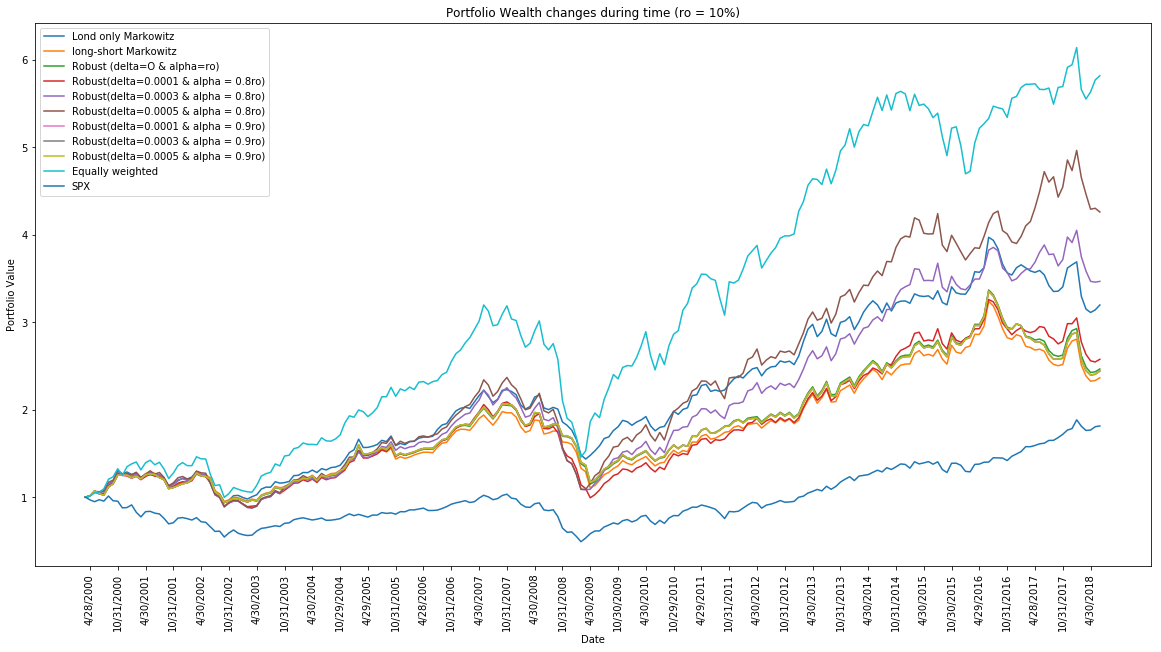

In [20]:
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Wealth changes during time (ro = 10%)')

plt.plot(Mark_l)
plt.plot(Mark_ls)
plt.plot(robust_Mark)
#plt.plot(robust_0000)
plt.plot(robust_0001)
#plt.plot(robust_0002)
plt.plot(robust_0003)
#plt.plot(robust_0004)
plt.plot(robust_0005)
plt.plot(robust_09_01)
plt.plot(robust_09_03)
plt.plot(robust_09_05)
plt.plot(Equal)
plt.plot(SPX[120:]/SPX[120])


plt.legend(['Lond only Markowitz',"long-short Markowitz"
            ,"Robust (delta=O & alpha=ro)"
 #           ,"Robust(delta=0.0000 & alpha = 0.8ro)"
            ,"Robust(delta=0.0001 & alpha = 0.8ro)"
   #         ,"Robust(delta=0.0002 & alpha = 0.8ro)"
            ,"Robust(delta=0.0003 & alpha = 0.8ro)"
     #       ,"Robust(delta=0.0004 & alpha = 0.8ro)"
            ,"Robust(delta=0.0005 & alpha = 0.8ro)"
            ,"Robust(delta=0.0001 & alpha = 0.9ro)"
            ,"Robust(delta=0.0003 & alpha = 0.9ro)"
            ,"Robust(delta=0.0005 & alpha = 0.9ro)"
            , "Equally weighted","SPX" ], loc='upper left')

date_index_range = window+1+np.array(range(Hreturns.shape[0]-window-1))
plt.xticks(date_index_range[::6]-window, Hreturns.index[date_index_range][::6], rotation='vertical')
plt.show()


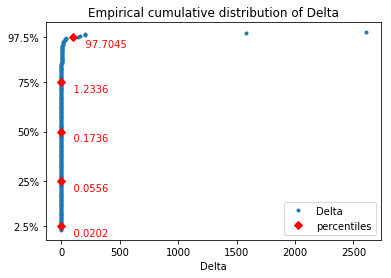

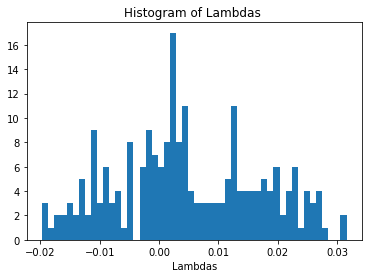

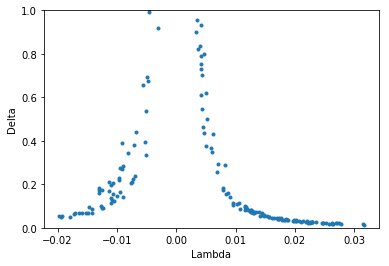

In [23]:
#test for getting historical deltas and lambdas and alphas
if True: #for initialization    
    lambdas=[]
    deltas=[]
    alphas=[]
    Start_index = window
    End_index = Hreturns.shape[0]
#we do the backtesting for 3 different combination of Starting assets:
for i in range(3):
    mu , sigma, R = Random_Stocks (window, Hreturns, samplesize,window)
    W = markowitz(mu,sigma,ro)[0]
    Active_portfolio = R.columns.values
    Portfolio_value=[1]
    date_index_range = Start_index+1+np.array(range(End_index-Start_index-1))
    for i in date_index_range:
        Portfolio_value.append(Portfolio_value[-1]*sum(W*(Hreturns[Active_portfolio].iloc[i]+1)))
        mu , sigma, R = Random_Stocks (i, Hreturns, samplesize,window,Active_portfolio)
        W,temp = markowitz(mu,sigma,ro)
        lambdas.append(temp)
        temp=delta(mu,sigma,R,ro ,W ,temp)
        deltas.append(temp)
        alphas.append(alpha(temp, ro, W))
        Active_portfolio = R.columns.values
        print(str(round(100*((i-window+1)/(Hreturns.shape[0]-window))))+"% of the backtesting is done!  ",end="\r")

def ecdf(data,txt):
    x_vers = np.sort(data)
    y_vers = np.arange(1, len(data)+1) / len(data)
    plt.title('Empirical cumulative distribution of '+str(txt) )
    plt.plot(x_vers,y_vers,marker=".",linestyle="none")
    percentiles=np.array([2.5,25,50,75,97.5])
    plt.yticks([.025,.25,.50,.75,.975], ["2.5%","25%","50%","75%","97.5%"])
    _ = plt.plot(np.percentile(data,percentiles), percentiles/100, marker='D', color='red' , linestyle='none')
    plt.legend((txt,'percentiles'), loc='lower right')
    plt.xlabel(txt)
    for i in percentiles:
        plt.text(np.percentile(deltas,i),(i-5)/100,'    '+str(round(np.percentile(deltas,i),4)),color="red")
    plt.show()
    
ecdf(deltas,"Delta")
plt.title('Histogram of Lambdas ' )
_=plt.hist(lambdas,bins=50)
plt.xlabel("Lambdas")
    
plt.show()

plt.plot(lambdas, deltas,".")
plt.ylabel("Delta")
plt.xlabel("Lambda")
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

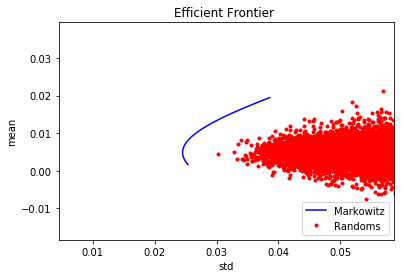

In [24]:
#efficient frontier
showMarkowitz = True
showRandoms =True
showRobust =False
Random_Stocks (i, Hreturns, samplesize,window)
def efficient_frontier( mu , sigma , R , method , ro_range=[0] ):
    if ro_range==[0]:
        ro_range_annual = [0.01*t+0.02 for t in range(25)]
        ro_range = (np.array(ro_range_annual)+1)**(1/12)-1
        ro_range = list(ro_range)
    if method =="markowitz" :
        portfolios = [markowitz(mu,sigma,ro)[0] for ro in ro_range]
    if method =="robust" :
        portfolios = [robust(mu,sigma,R,ro) for ro in ro_range]     
    portfolios = pd.DataFrame(portfolios).T
    returns = np.zeros(len(ro_range))
    risks = np.zeros(len(ro_range))
    for i in range(len(ro_range)):
        x=portfolios.iloc[:,i]
        returns[i] = np.matmul(mu,x)
        risks[i] = np.sqrt(np.matmul(np.matmul(x.T , sigma),x)) 
    return returns,risks

plt.title('Efficient Frontier ' )
plt.ylabel('mean')
plt.xlabel('std')
if showMarkowitz:
    returns1, risks1=efficient_frontier(mu,sigma,R,"markowitz")
    plt.plot(risks1, returns1, '-',color="blue")
if showRobust:
    returns2, risks2=efficient_frontier(mu,sigma,R,"robust")
    plt.plot(risks2, returns2,'-',color="green")

if showRandoms:
    n = 5000
    x = [np.random.random(size=len(mu))-0.5 for x in range(n)]
    x = pd.DataFrame(x)
    x = pd.DataFrame([[float(i)/sum(x.iloc[j,:]) for i in x.iloc[j,:]] for j in range(n)])
    randreturns = np.matmul(mu , x.T)
    randrisks = [np.sqrt(np.matmul(np.matmul(x.iloc[j,:].T , sigma),x.iloc[j,:])) for j in range(n)]
    plt.plot(randrisks, randreturns,'.',color="red")
    axes = plt.gca()
    axes.set_xlim([(min(risks1)-0.02),(max(risks1)+0.02)])
    axes.set_ylim([(min(returns1)-0.02),(max(returns1)+0.02)])

plt.legend(list(compress(['Markowitz','Robust','Randoms'],[showMarkowitz , showRobust,showRandoms])), loc='lower right')
plt.show()



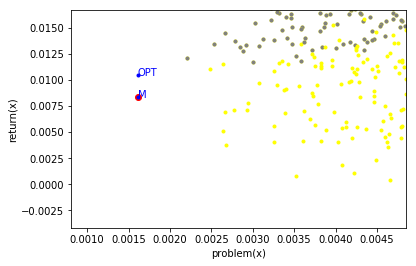

In [27]:
# the efficient frontier for new problem instead of risk
# play around with the xlim and ylim to see something beautiful
ro=.1/12
hjh=5000

mu,sigma,R = Random_Stocks (window, Hreturns, samplesize,window)
Wm , Lambda1 =markowitz (mu, sigma, ro)
Wm=np.array(Wm)
alph = ro *0.6
delt = 0.0003
Wopt = np.array(weight_optimizer( mu , sigma , alph, delt,Wm))
def problem(W):
    return (np.sqrt(np.matmul(np.matmul(W.T , sigma),W))  + np.sqrt(delt)*np.linalg.norm(W))**2
xsol = (Wm) / sum(Wm)
sol = problem(Wm)
for i in range(hjh):
    W = np.random.random(samplesize)-0.5
    x = W / sum(W)
    y = problem(x)
    plt.plot(y, sum(x*mu),  '.',color="yellow")
    if sum(x*mu) - np.sqrt(delt) * np.linalg.norm(x) - alph > 0 :
        plt.plot(y, sum(x*mu),  '.',color="Gray")     
        if y < sol :
            sol = y
            xsol =x 
plt.ylabel('return(x)')
plt.xlabel('problem(x)')
axes = plt.gca()
axes.set_xlim([0.5*sol,3*sol])
axes.set_ylim([-.5*ro,2*ro])
plt.plot(sol, sum(xsol*mu),  '-o',color="red")
plt.plot( problem(Wm),sum(Wm*mu), '.',color="blue")
plt.text(problem(Wm),sum(Wm*mu),'M',color="blue")

plt.plot( problem(Wopt),sum(Wopt*mu), '.',color="blue")
plt.text(problem(Wopt),sum(Wopt*mu),'OPT',color="blue")

plt.show()      
